In [8]:
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
from pathlib import Path
import os
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd
import seaborn as sns
import pandas as pd
from tqdm import tqdm
from shapely import wkt
from shapely.geometry import box
import gc
import pandas as pd
import pickle
import cartopy.crs as ccrs
import geopandas as gpd

In [2]:
import os

def count_files_with_extension(directory, extension):
    count = 0
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith(extension):
                count += 1
    return count

# Example usage:
directory_path = '/home/udas/Desktop/UD_Data_Copy/b.final_burned_area'
extension = '.nc'  # specify the extension
count = count_files_with_extension(directory_path, extension)
print(f'There are {count} files with the {extension} extension.')


There are 17859 files with the .nc extension.


### Fire Distribution Per Year

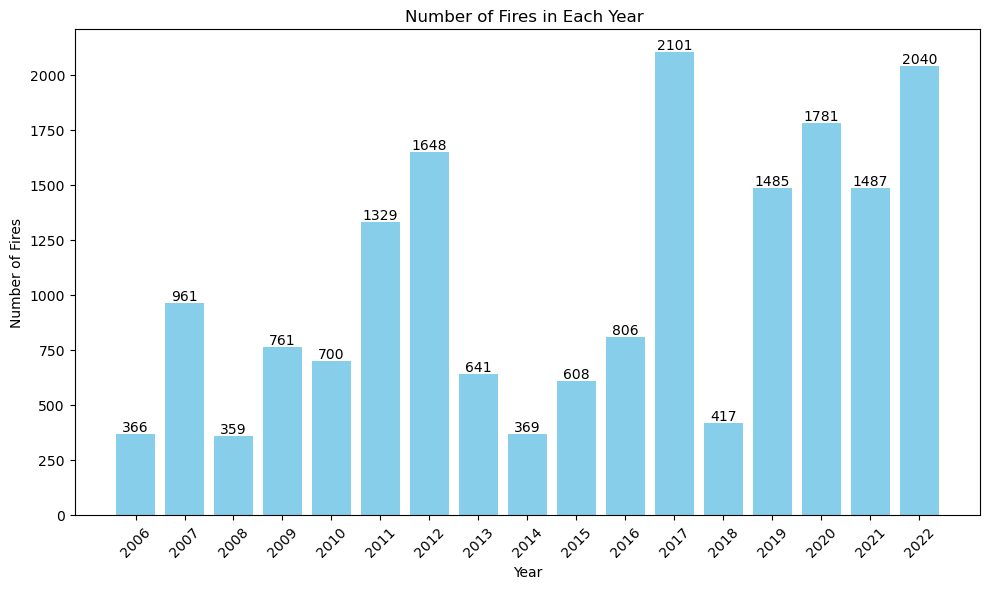

In [3]:



directory = '/home/udas/Desktop/UD_Data_Copy/b.final_burned_area'
# Dictionary to store year and number of files
year_file_count = {}

# Iterate over each subfolder in the directory
for folder in os.listdir(directory):
    folder_path = os.path.join(directory, folder)
    
    # Check if it's a directory
    if os.path.isdir(folder_path):
        # Count the number of files in the folder
        num_files = len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])
        year_file_count[folder] = num_files

# Sort the dictionary by year (folder name)
year_file_count = dict(sorted(year_file_count.items()))

# Plotting
plt.figure(figsize=(10, 6))
bars=plt.bar(year_file_count.keys(), year_file_count.values(), color='skyblue')
plt.xlabel('Year')
plt.ylabel('Number of Fires')
plt.title('Number of Fires in Each Year ')
plt.xticks(rotation=45)

#Adding the number labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')


plt.tight_layout()
plt.show()


### Distribution of Burned Area Sizes

In [4]:
def get_burned_area_size(root,area_file):

    with open(area_file,'ab') as f:
        for year in tqdm(os.listdir(root)):
            year_path=os.path.join(root,year)
            # print(year_path)

            if os.path.isdir(year_path):
                for file in tqdm(os.listdir(year_path),leave=False):
                    if file.endswith(".nc"):
        
                        file_path = os.path.join(year_path,file)
                        # print(file_path)
                        dataset=xr.open_dataset(file_path)
                        ignition_point=dataset['ignition_points'].isel(time=-1).values
                        # print(ignition_point.shape)
                        fire_indices=np.argwhere(ignition_point>0)
                        # print(f' fire indices shape {fire_indices.shape}')
                        if fire_indices.shape[0]>1:
                            area=0
                            for idx in fire_indices:
                                # print(f'Inside multiple ignitions')
                                row,col=idx
                                # print(f'area is {area}')
                                # print(f'ind area is {ignition_point[row,col]}')
                                # print(f'sum is {area+ignition_point[row,col]}')
                                area+=ignition_point[row,col]
                                # print(f'new area is {area}')
                            area_list.append(area)
                        else:
                            # print(f'Inside single ignition')
                            # print(fire_indices)
                            row,col=fire_indices[0]
                            # print(row,col)
                            area=ignition_point[row,col]
                            # print(f'area is {area}')
                            area_list.append(area)
                        pickle.dump(area,f)
                        dataset.close()

    return area_list

def pickle_load_area(filepath):
    with open(filepath, 'rb') as f:
        area_list = []
        while True:
            try:
                # Load individual areas and append to the list
                area_list.append(pickle.load(f))
            except EOFError:
                break
    return area_list

def plot_area_size(area_list):
    plt.figure(figsize=(10, 6))
    plt.hist(area_list, bins=50, color='lightcoral', edgecolor='black')
    plt.xlabel('Burned Area (in hectares)')
    plt.ylabel('Frequency')
    plt.title('Distribution of Burned Areas from Ignition Points')
    plt.grid(True)
    plt.tight_layout()
    plt.show()



In [5]:
area_file='./areas.pkl'
# area_list=get_burned_area_size(directory,area_file)
pick_area=pickle_load_area(area_file)
print(pick_area[:5])

# plot_area_size(area_list)

[1471.0, 50.0, 144.0, 458.0, 41.0]


In [7]:
max(pick_area)

107602.0

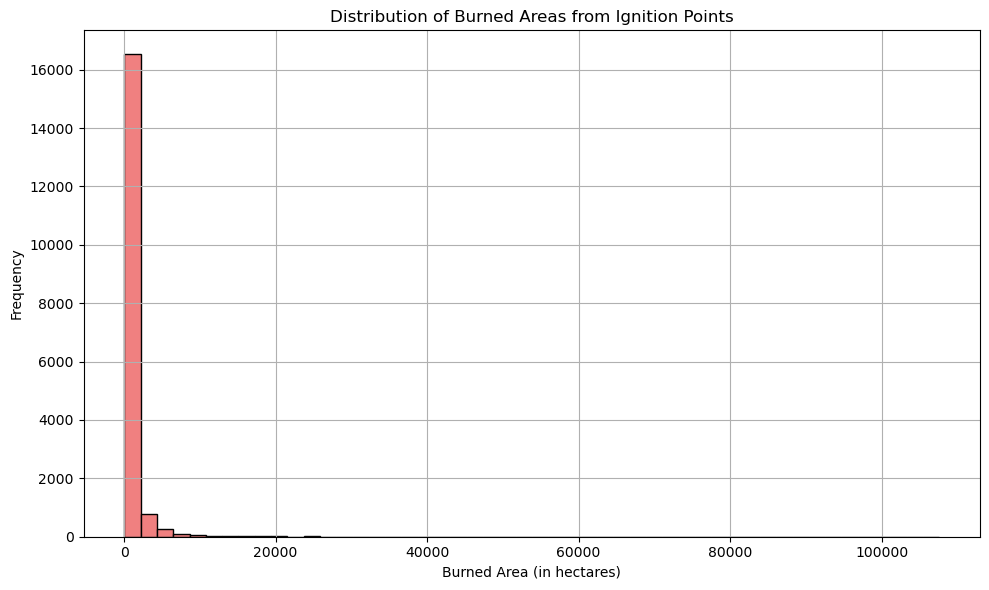

In [6]:
plot_area_size(pick_area)

In [17]:
def area_count_tabular(area_list,bins=50):
    count,bin_edges=np.histogram(area_list,bins=bins)
    bin_ranges=[]
    for i in range(len(bin_edges)-1):
        bin_ranges.append(f"{bin_edges[i]:.2f}-{bin_edges[i+1]:.2f}")
    df=pd.DataFrame({'burned_area hectares':bin_ranges,'count':count})
    return df 

df=area_count_tabular(pick_area,50)
print(df)

   burned_area hectares  count
0         30.00-2181.44  16524
1       2181.44-4332.88    767
2       4332.88-6484.32    280
3       6484.32-8635.76     95
4      8635.76-10787.20     68
5     10787.20-12938.64     30
6     12938.64-15090.08     20
7     15090.08-17241.52     15
8     17241.52-19392.96      8
9     19392.96-21544.40      8
10    21544.40-23695.84      6
11    23695.84-25847.28      9
12    25847.28-27998.72      5
13    27998.72-30150.16      3
14    30150.16-32301.60      0
15    32301.60-34453.04      2
16    34453.04-36604.48      4
17    36604.48-38755.92      0
18    38755.92-40907.36      0
19    40907.36-43058.80      4
20    43058.80-45210.24      2
21    45210.24-47361.68      2
22    47361.68-49513.12      0
23    49513.12-51664.56      4
24    51664.56-53816.00      0
25    53816.00-55967.44      1
26    55967.44-58118.88      0
27    58118.88-60270.32      0
28    60270.32-62421.76      0
29    62421.76-64573.20      0
30    64573.20-66724.64      0
31    66

### Countrywise

In [ ]:
ds=xr.open_dataset('/home/udas/Desktop/UD_Data_Copy/b.final_burned_area/2008/sample_1327.nc')
ds

In [10]:
def get_grid_extent(ds):
    
    long=ds['x'].values
    lat=ds['y'].values
    lat_min,lat_max=lat.min(),lat.max()
    long_min,long_max=long.min(),long.max()
    coordinates=lat_min,lat_max,long_min,long_max
    # print(coordinates)
    return coordinates

def get_countries(grid_extent,world):

    

    # Define your bounding box
    lat_min, lat_max, long_min, long_max = grid_extent

    # Create a GeoDataFrame from the bounding box
    bbox = gpd.GeoDataFrame(geometry=[box(long_min, lat_min, long_max, lat_max)], crs='EPSG:4326')
    # print(bbox)
    # Find countries that intersect with the bounding box
    intersecting_countries = gpd.sjoin(world, bbox, how='inner', op='intersects')

    # Print the intersecting countries
    # print(intersecting_countries['name'])

    return intersecting_countries['name']

def add_country_attribute(filepath,world):
    ds=xr.open_dataset(filepath,mode='a')
    grid_extent=get_grid_extent(ds)
    countries=get_countries(grid_extent,world)
    ds.attrs['countries']=','.join(countries)
    ds_2=ds
    ds.close()
    ds_2.to_netcdf(filepath)
    ds2.close()

def modify_folder_attribute(root,year):
    # Load a GeoJSON file containing country boundaries
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    for year_val in tqdm(os.listdir(root)):
        if year_val==year:
            folder_path=os.path.join(root,year_val)
            # print(folder_path)
            if os.path.isdir(folder_path) :
                # print('hereee')
                for file in tqdm(os.listdir(folder_path)):
                    # print(file) 
                    if file.endswith(".nc"):
                        file_path=os.path.join(folder_path,file)
                        # print('here')
                        # get_countries(get_grid_extent(xr.open_dataset(file_path)))
                        add_country_attribute(file_path,world)

In [11]:
modify_folder_attribute('/home/udas/Desktop/UD_Data_Copy/b.final_burned_area','2022')

/tmp/ipykernel_131951/12894290.py:41: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
  0%|          | 0/18 [00:00<?, ?it/s]/tmp/ipykernel_131951/12894290.py:54: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  add_country_attribute(file_path,world)
 78%|███████▊  | 14/18 [00:00<00:00, 859.94it/s]


PermissionError: [Errno 13] Permission denied: b'/home/udas/Desktop/UD_Data_Copy/b.final_burned_area/2022/sample_16971.nc'

<xarray.Dataset>
Dimensions:               (y: 64, x: 64, time: 1)
Coordinates:
  * time                  (time) datetime64[ns] 2022-01-02
  * x                     (x) float64 -6.178 -6.168 -6.158 ... -5.554 -5.544
  * y                     (y) float64 43.39 43.38 43.37 ... 42.78 42.77 42.76
Data variables: (12/30)
    aspect                (y, x) float32 ...
    burned_areas          (time, y, x) float32 ...
    curvature             (y, x) float32 ...
    d2m                   (time, y, x) float32 ...
    dem                   (y, x) float32 ...
    ignition_points       (time, y, x) float32 ...
    ...                    ...
    lc_settlement         (y, x) float32 ...
    lc_shrubland          (y, x) float32 ...
    lc_sparse_vegetation  (y, x) float32 ...
    lc_water_bodies       (y, x) float32 ...
    lc_wetland            (y, x) float32 ...
    population            (y, x) float32 ...